In [12]:
import do_mpc
import numpy as np
import matplotlib.pyplot as plt

from data.data_generation import data_generation
from src.model.dynamics_model import dynamics_model
from src.model.mpc_controller import mpc_controller
from src.model.mhe_estimator import mhe_estimator
from src.model.simulator import simulator
from src.util.question_selector import question_selector, benchmark1, benchmark2, manual_scheduling
from src.util.constants import *

from src.util.plotting import plotter

from casadi import lt

In [13]:
def tla_generation():
    C1 = 0*np.eye(100, 5)
    C1[:,0] = np.random.uniform(low=0.0, high=1.0, size=(len(C1),))
    C1 = C1[C1[:,0].argsort()]
    C2 = 0*np.eye(100, 5)
    C2[:,:2] = np.random.uniform(low=0.0, high=1.0, size=(len(C1),2))
    C2 = C2[C2[:,1].argsort()]
    C3 = 0*np.eye(100, 5)
    C3[:,:3] = np.random.uniform(low=0.0, high=1.0, size=(len(C1),3))
    C3 = C3[C3[:,2].argsort()]
    C4 = 0*np.eye(100, 5)
    C4[:,:4] = np.random.uniform(low=0.0, high=1.0, size=(len(C1),4))
    C4 = C4[C4[:,3].argsort()]
    C5 = 0*np.eye(100, 5)
    C5[:,:5] = np.random.uniform(low=0.0, high=1.0, size=(len(C1),5))
    C5 = C5[C5[:,4].argsort()]
    tla = np.concatenate((C1, C2, C3, C4, C5))
    idx1 = np.sort(np.append(np.random.randint(100, size=4), 99))
    idx2 = np.sort(np.append(np.random.randint(100, size=4), 99))
    idx3 = np.sort(np.append(np.random.randint(100, size=4), 99))
    idx4 = np.sort(np.append(np.random.randint(100, size=4), 99))
    idx5 = np.sort(np.append(np.random.randint(100, size=4), 99))
    scheduled_tla = 0*np.eye(32,5)
    scheduled_tla[:5,:] = C1[idx1,:]
    scheduled_tla[5:10,:] = C2[idx2,:]
    scheduled_tla[10:15,:] = C3[idx3,:]
    scheduled_tla[15:20,:] = C4[idx4,:]
    scheduled_tla[20:25,:] = C5[idx5,:]
    scheduled_tla[25:,:] = C5[np.random.randint(100, size=len(scheduled_tla[25:,:])),:]
    return tla, scheduled_tla

In [14]:
''''
Get configured do-mpc modules
'''
model = dynamics_model(S, C, K)
mpc = mpc_controller(model)
mhe = mhe_estimator(model)
sim = simulator(model)
#estimator = do_mpc.estimator.StateFeedback(model)

dynamics_model(): model type is discrete and symvars are SX


C:\Users\ricca\Anaconda3\envs\learning_analytics\lib\site-packages\do_mpc\controller.py:760: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [15]:
%%capture
'''
Setup graphic
'''
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
#mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(3,1, sharex=True, figsize=(10, 9))
fig.align_ylabels()

mpc_plot = do_mpc.graphics.Graphics(mpc.data)
mhe_plot = do_mpc.graphics.Graphics(mhe.data)
sim_plot = do_mpc.graphics.Graphics(sim.data)

ax[0].set_title('Estimated knowledge:')
sim_plot.add_line('_x', 'x', ax[0])
mhe_plot.add_line('_x', 'x', ax[0])

ax[0].legend(
    sim_plot.result_lines['_x', 'x']+mhe_plot.result_lines['_x', 'x'],
    ['Recorded', 'Estimated'], title='Knowledge')

ax[1].set_title('TLA time:')
sim_plot.add_line('_x', 'T_total', ax[1])
sim_plot.add_line('_u', 'T', ax[1])

ax[1].legend(
    sim_plot.result_lines['_x', 'T_total'] + sim_plot.result_lines['_u', 'T'],
    ['T total', 'TLA duration']
    )

ax[2].set_title('TLA difficulty:')
sim_plot.add_line('_u', 'h', ax[2])
#mpc_plot.add_line('_u', 'h', ax[2])

for mpc_line_i, mhe_line_i, sim_line_i in zip(mpc_plot.result_lines.full, mhe_plot.result_lines.full, sim_plot.result_lines.full):
    mhe_line_i.set_color(sim_line_i.get_color())
    mhe_line_i.set_color(sim_line_i.get_color())
    mpc_line_i.set_linestyle('--')
    mhe_line_i.set_alpha(0.5)
    mhe_line_i.set_linewidth(5)

ax[0].set_ylabel('knowledge')
ax[1].set_ylabel('TLA time [h]')
ax[2].set_ylabel('TLA difficulty')
ax[2].set_xlabel('time [day]')

for ax_i in ax:
    ax_i.axvline(1.0)

# fig.tight_layout()
# plt.ion()

In [16]:
'''
Set initial state
'''
np.random.seed(seed=42)

# Obtain all configured modules and run the loop
phi, psi = data_generation()  # students, questions, involvements
tla, schedule_tla = tla_generation() 
#q_tracker = np.zeros((S, 2 * C), dtype=bool)
q_tracker = np.zeros((S, len(tla)), dtype=bool)
''' Use different initial state for the true system (simulator) and for MHE / MPC '''
x0_true = np.append(phi[4], [0, 0])
x0 = np.zeros(model.n_x)
x0[0] = np.random.uniform(low=0.0, high=0.6)
x0[1] = np.random.uniform(low=0.0, high=x0[0])
x0[2] = np.random.uniform(low=0.0, high=x0[0])
x0[3] = np.random.uniform(low=0.0, high=x0[1])
x0[4] = np.random.uniform(low=0.0, high=x0[1]) 
#x0 = np.random.uniform(low=0.0, high=0.4, size=model.n_x)#.reshape((model.n_x, 1))                  # --> Shape = 10

# Initialize MPC, Sim and MHE. Use different initial state for the true system (simulator) and for MHE / MPC
mpc.x0 = x0
sim.x0 = x0_true
mhe.x0 = x0
#estimator.x0 = x0

# Set initial guess for MHE/MPC based on initial state.
mpc.set_initial_guess()
mhe.set_initial_guess()

data_generation() constructed student data with shape (50, 5) and questions data with shape (2000, 5)


In [17]:
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# # Customizing Matplotlib:
# mpl.rcParams['font.size'] = 18
# mpl.rcParams['lines.linewidth'] = 3
# mpl.rcParams['axes.grid'] = True
# mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
# mhe_graphics = do_mpc.graphics.Graphics(mhe.data)
# sim_graphics = do_mpc.graphics.Graphics(sim.data)

In [18]:
# %%capture
# # We just want to create the plot and not show it right now. This "inline magic" supresses the output.
# fig, ax = plt.subplots(2,2, sharex=True, figsize=(16,9))
# fig.align_ylabels()

In [19]:
# %%capture
# for g in [sim_graphics, mpc_graphics, mhe_graphics]:
#     # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
#     g.add_line(var_type='_x', var_name='x', axis=ax[0][0])
#     g.add_line(var_type='_x', var_name='days', axis=ax[0][1])

#     g.add_line(var_type='_u', var_name='h', axis=ax[1][0])
#     g.add_line(var_type='_u', var_name='T', axis=ax[1][1])

#     # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
#     #g.add_line(var_type='_u', var_name='w', axis=ax[1])
#     #g.add_line(var_type='_z', var_name='w', axis=ax[1][0])
#     #g.add_line(var_type='_z', var_name='n_involved_skills', axis=ax[2][1])
# ax[0][0].set_ylabel('knowledge')
# ax[0][1].set_ylabel('T total [hours]')
# ax[1][0].set_ylabel('difficulty')
# ax[1][1].set_ylabel('T [hours]')
# ax[0][0].set_xlabel('time [days]')

In [20]:
# for line_i in mhe_graphics.result_lines.full:
#     line_i.set_alpha(0.4)
#     line_i.set_linewidth(6)

Free response model

In [21]:
# u0 = np.zeros((6,1))
# #u0[0] += 0.4
# #u0[-1] += 2.5
# for i in range(100):
#     if i % 7 == 0 or i % 7 == 2 or i % 7 == 4:
#         u0[0] = 0.4
#         u0[-1] = 2  
#     else:
#         u0[0] = 0
#         u0[-1] = 3
#     #sim.make_step(u0)
#     y0 = sim.make_step(u0, w0=0.01*np.random.randn(model.n_w,1))
#     x0 = mhe.make_step(y0)

In [22]:
# sim_plot.plot_results()
# mhe_plot.plot_results()
# # Reset the limits on all axes in graphic to show the data.
# sim_plot.reset_axes()
# mhe_plot.reset_axes()
# # Show the figure:
# fig

In [23]:
sim.reset_history()
mpc.reset_history()
mhe.reset_history()

In [24]:
def manual_scheduling(scheduled_tla, tracker):
    return scheduled_tla[tracker]

In [25]:
#%%capture
use_mpc = False
tracker = 0


for i in range(60):

    if use_mpc:
        # Find optimal question
        u0_tilde = mpc.make_step(x0)
        _h = u0_tilde[:K]     # [0.5, 0.2, 0, 0, 0, 0, 0, 0, 0]
        _T = u0_tilde[-1]        # 50

        # Select the question closest to optimal.
        if i % 7 == 0 or i % 7 == 2 or i % 7 == 4:
            _h, q_tracker = question_selector(_h, tla, 0, q_tracker)
        else:
            _h = np.zeros(K)
    else:
        _T = [3]
        if i % 7 == 0 or i % 7 == 2 or i % 7 == 4:
            _h = manual_scheduling(schedule_tla, tracker)
            tracker += 1
        else:
            _h = np.zeros(K)
            
    u0 = np.concatenate((_h, _T))[:, np.newaxis]
    # Simulate with process and measurement noise
    #x_prev = sim.x0
    y0 = sim.make_step(u0, w0=0.01 * np.random.randn(model.n_w, 1))
    x0 = mhe.make_step(y0)
    #print(i)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

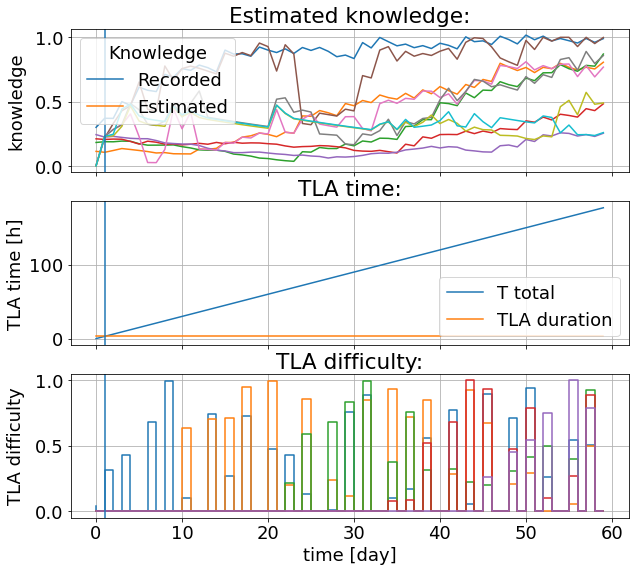

In [26]:
# Plot predictions from t=0
#mpc_graphics.plot_predictions(t_ind=5)
# Plot results until current time
#mpc_plot.plot_results()
sim_plot.plot_results()
mhe_plot.plot_results()
#mpc_plot.plot_results()
#mpc_plot.reset_axes()
sim_plot.reset_axes()
mhe_plot.reset_axes()
#mpc_plot.reset_axes()
fig

In [28]:
do_mpc.data.save_results([mpc, mhe, sim], 'benchmark')

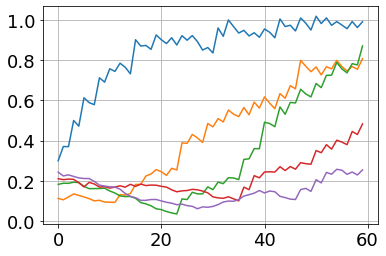

In [29]:
plt.plot(sim.data._time, sim.data._x[:,:-2])
#plt.plot(sim.data._time, mhe.data._x[:,:-2])